In [17]:
library(dplyr)
library(Rtsne)
library(cluster)
library(data.table)
library(ggplot2)

In [18]:
# Set the common exported dataset directory
dataset_dir <- file.path(getwd(), 'dataset', 'exported')

In [19]:
# Read the repeat dataset. It returns a data.table type
profile_csv <- file.path(dataset_dir, 'profile')
profile_df <- fread(profile_csv)

In [20]:
profile_df$gender <- factor(profile_df$gender)
profile_df$customer_id <- factor(profile_df$customer_id)
profile_df$city_code <- factor(profile_df$city_code)

# 2. Clustering

Why I didn't use log transform:  
1. The dataset is from a pivot table. One customer may have bought only from the bath subcategory, but another one bought from kitchen and bags_men. There are a lot of zeros, which is normal for pivoting to get the sales per customer per subcategory. If I drop those zeroes, I would be left with no data at all.  
2. The means of each subcategory are near to each other.  
3. When I tested with the log transform, the medoids were only sales for ```total_bath```. It did not consider that some clusters have sales on 

In [33]:
gower_dist <- daisy(profile_df[, -c('customer_id')],
                        metric = 'gower',
                   type = list(logratio = 3))

In [34]:
# Calculate silhoutte width for many k using PAM
sil_width <- c(NA)
for (i in 2:10) {
    pam_fit <- pam(gower_dist, diss=TRUE, k=i)
    sil_width[i] <- pam_fit$silinfo$avg.width
}

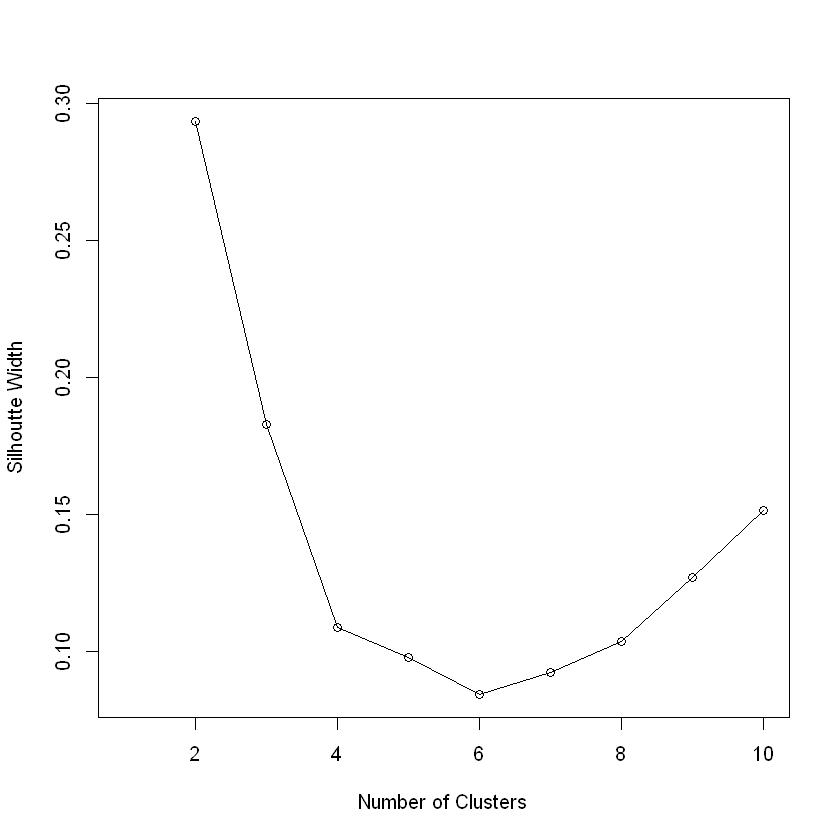

In [35]:
# Plot the silhoutte width
plot(1:10, sil_width,
     xlab = "Number of Clusters",
     ylab = "Silhoutte Width")
lines(1:10, sil_width)

In [36]:
set.seed(7)

In [37]:
pam_fit <- pam(gower_dist, diss = TRUE, k = 10)

In [38]:
pam_results <- profile_df %>%
    dplyr::select(-c(customer_id)) %>%
    mutate(cluster = pam_fit$clustering) %>% 
    group_by(cluster) %>%
    do(the_summary = summary(.))

In [39]:
pam_results$the_summary

[[1]]
 total_bags_men   total_bags_women   total_bath     total_clothing_kids
 Min.   :   0.0   Min.   :   0.0   Min.   :   0.0   Min.   :   0.0     
 1st Qu.:   0.0   1st Qu.:   0.0   1st Qu.:   0.0   1st Qu.:   0.0     
 Median :   0.0   Median :   0.0   Median :   0.0   Median :   0.0     
 Mean   : 510.6   Mean   : 321.6   Mean   : 479.5   Mean   : 390.5     
 3rd Qu.:   0.0   3rd Qu.:   0.0   3rd Qu.:   0.0   3rd Qu.:   0.0     
 Max.   :8370.4   Max.   :7743.8   Max.   :7602.4   Max.   :8141.6     
                                                                       
 total_clothing_men total_clothing_women total_furnishing total_kitchen 
 Min.   :   0.0     Min.   :   0.0       Min.   :   0.0   Min.   :   0  
 1st Qu.:   0.0     1st Qu.:   0.0       1st Qu.:   0.0   1st Qu.:   0  
 Median :   0.0     Median :   0.0       Median :   0.0   Median :   0  
 Mean   : 401.1     Mean   : 311.7       Mean   : 345.3   Mean   : 304  
 3rd Qu.:   0.0     3rd Qu.:   0.0       3rd Qu.:   0

In [40]:
profile_df[pam_fit$medoids, ]

customer_id,total_bags_men,total_bags_women,total_bath,total_clothing_kids,total_clothing_men,total_clothing_women,total_furnishing,total_kitchen,total_tools,gender,city_code,birth_year
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>
275171,0,0,1001.130,0,0,0,0,0,0,F,9,1974
270772,0,0,1425.450,0,0,0,0,0,0,M,4,1978
271565,0,0,2582.385,0,0,0,0,0,0,M,8,1975
274649,0,0,3618.875,0,0,0,0,0,0,F,7,1979
274033,0,0,4594.590,0,0,0,0,0,0,F,1,1982
269385,0,0,4498.455,0,0,0,0,0,0,M,2,1981
267681,0,0,1617.720,0,0,0,0,0,0,M,5,1983
273083,0,0,1538.160,0,0,0,0,0,0,F,10,1987
271790,0,0,877.370,0,0,0,0,0,0,F,5,1984


In [41]:
tsne_obj <- Rtsne(gower_dist, is_distance = TRUE)

In [42]:
tsne_data <- tsne_obj$Y %>%
  data.frame() %>%
  setNames(c("X", "Y")) %>%
  mutate(cluster = factor(pam_fit$clustering),
         customer_id = profile_df$customer_id)

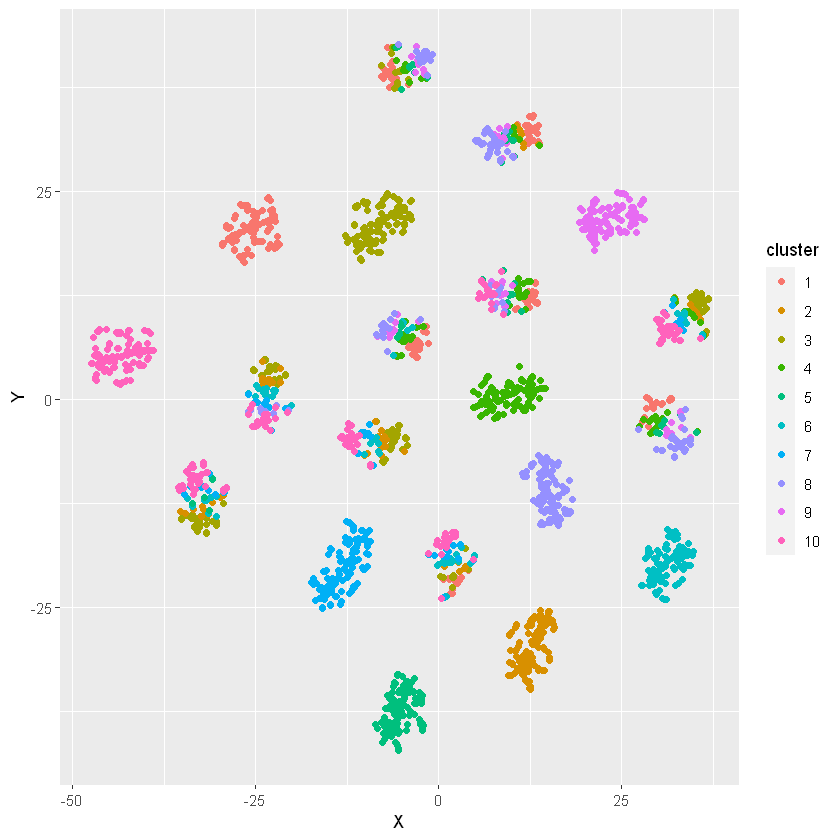

In [43]:
ggplot(aes(x = X, y = Y), data = tsne_data) +
  geom_point(aes(color = cluster))

In [44]:
# write.csv(tsne_data, file.path(dataset_dir, 'profile_tsne_data'), row.names=TRUE)